In [23]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import re
import numpy as np
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


In [138]:
df = pd.read_csv("data/df_tree.csv")
df1 = pd.read_excel('raw_data/2022426114414371694040KKAREAL.xlsx', header=2, usecols = "B:K")


In [139]:
df1 = df1.dropna()
df1 = df1.transpose()
df1 = df1.reset_index()

In [144]:
df1.rename(columns = {"index":'district', 0:'area_m2'}, inplace = True)
df1['district'] = df1['district'].str.replace("Bydel - ", "")
df1['district'] = df1['district'].str.replace("/", "-")
df1

,district,area_m2
0,Indre By,9432832.0
1,Østerbro,9860777.0
2,Nørrebro,4104694.0
3,Vesterbro-Kgs Enghave,8371719.0
4,Valby,9233781.0
5,Vanløse,6698505.0
6,Brønshøj-Husum,8738408.0
7,Bispebjerg,6832786.0
8,Amager Øst,9784081.0
9,Amager Vest,19370227.0


In [26]:
df.year = df.year.apply(int)
df.id = df.id.astype("category")

Amager Vest
Amager Øst
Bispebjerg
Brønshøj-Husum
Indre By
Nørrebro
Valby
Vanløse
Vesterbro-Kongens Enghave
Østerbro


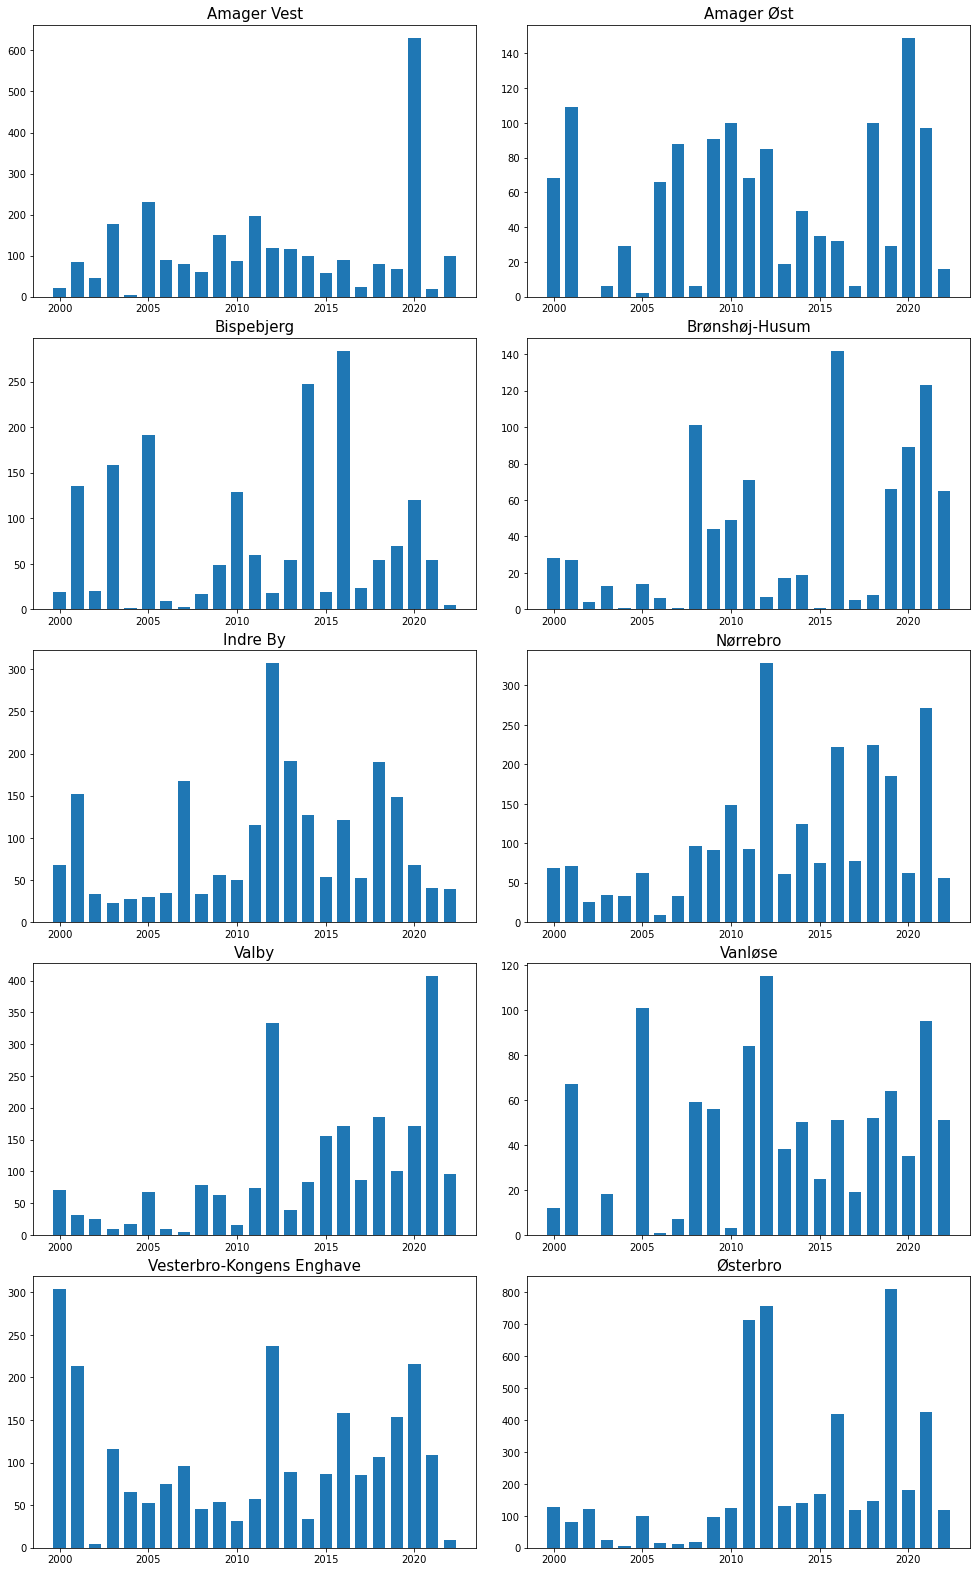

In [51]:
# Bar plot of planted trees over the years in the different districts

df_districts = df.groupby(["year", "district"]).size().reset_index()
temp = df_districts[df_districts["district"] == "Amager Vest"]
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize=(14,22))
figure.tight_layout(pad=2.0)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
i = 1
districts = df_districts.district.unique()
for (ax, dist) in zip(axes, districts):
    print(dist)
    temp = df_districts[df_districts["district"] == dist]
    ax.bar(temp['year'],temp[0], width=0.7)
    ax.set_title(dist, fontsize=15)
    #ax.set_xticks('')
    #ax.set_ylim([0,4.0])
     # ylabel 
    # if (i % 2) != 0: 
    #     ax.set_ylabel('P(crime|district)/P(crime)', fontsize=15)
    # if ax == ax9 or ax == ax10:
    #     ax.set_xticks(dat['Category'])
    #     ax.set_xticklabels(dat['Category'], rotation=90)
    i = i + 1


In [57]:
tree_species = df["species"].value_counts().sort_values(ascending = False)[1:11].index.to_list() # get top 10 tree species 
df_species = df[df["species"].isin(tree_species)].groupby(["district", "species"]).size().reset_index()
df_species

,district,species,0
0,Amager Vest,Ask,222
1,Amager Vest,Eg,146
2,Amager Vest,El,242
3,Amager Vest,Kirsebær/Blomme,161
4,Amager Vest,Lind,129
...,...,...,...
95,Østerbro,Løn,160
96,Østerbro,Platan,214
97,Østerbro,Robinie,133
98,Østerbro,Røn,291


Amager Vest
Amager Øst
Bispebjerg
Brønshøj-Husum
Indre By
Nørrebro
Valby
Vanløse
Vesterbro-Kongens Enghave
Østerbro


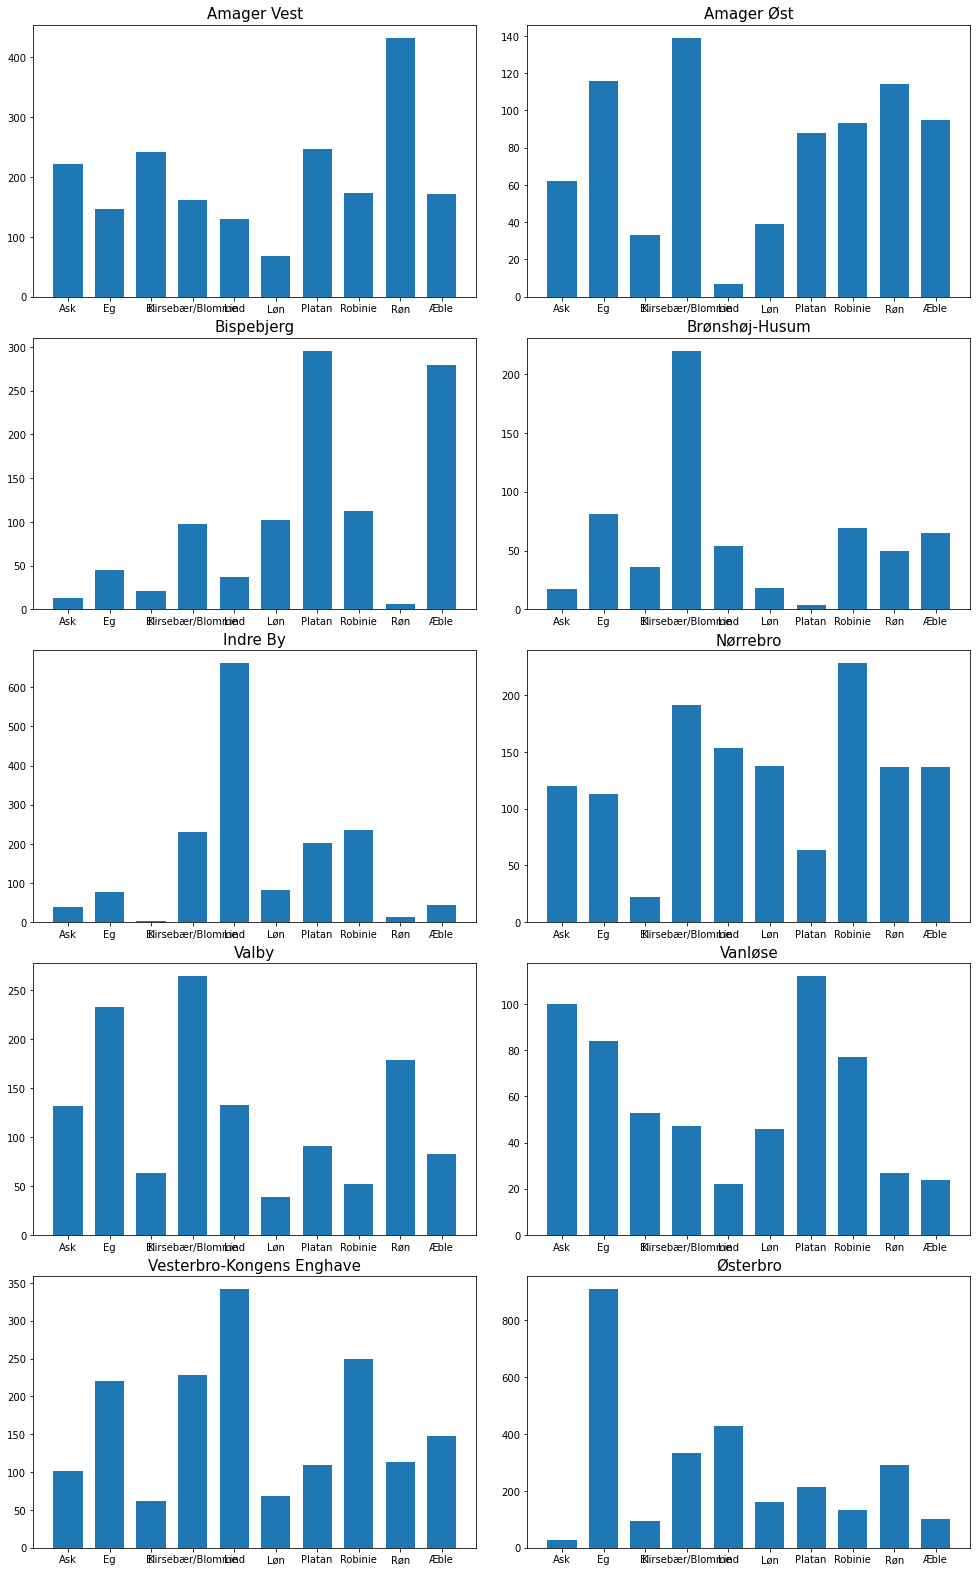

In [61]:
# Bar plot of different species in the different districts
tree_species = df["species"].value_counts().sort_values(ascending = False)[1:11].index.to_list() # get top 10 tree species 
df_species = df[df["species"].isin(tree_species)].groupby(["district", "species"]).size().reset_index()
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize=(14,22))
figure.tight_layout(pad=2.0)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
i = 1
for (ax, dist) in zip(axes, districts):
    print(dist)
    temp = df_species[df_species["district"] == dist]
    ax.bar(temp['species'],temp[0], width=0.7)
    ax.set_title(dist, fontsize=15)
    #ax.set_xticks('')
    #ax.set_ylim([0,4.0])
     # ylabel 
    # if (i % 2) != 0: 
    #     ax.set_ylabel('P(crime|district)/P(crime)', fontsize=15)
    # if ax == ax9 or ax == ax10:
    #     ax.set_xticks(dat['Category'])
    #     ax.set_xticklabels(dat['Category'], rotation=90)
    i = i + 1

Amager Vest
Amager Øst
Bispebjerg
Brønshøj-Husum
Indre By
Nørrebro
Valby
Vanløse
Vesterbro-Kongens Enghave
Østerbro


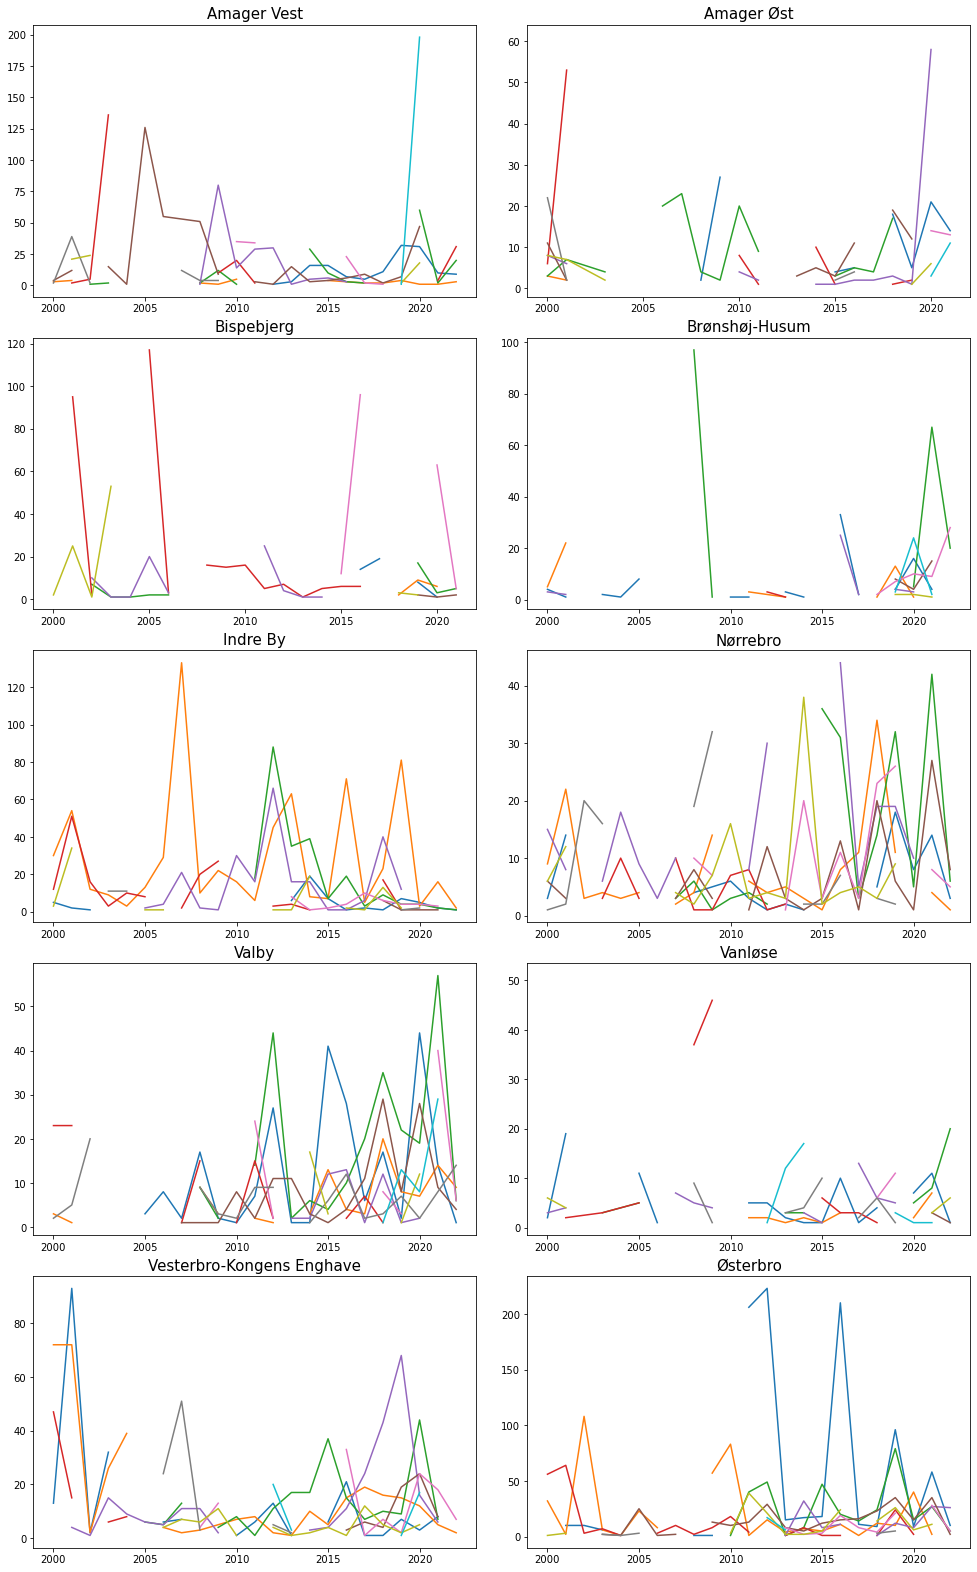

In [79]:
table = pd.pivot_table(df, values='id', index=["year", "district"],
                    columns=['species'], aggfunc="count")
table = table[tree_species]
table = table.reset_index()
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize=(14,22))
figure.tight_layout(pad=2.0)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
i = 1
for (ax, dist) in zip(axes, districts):
    print(dist)
    temp = table[table["district"] == dist]
    for j in tree_species:
        ax.plot(temp["year"], temp[j])
    ax.set_title(dist, fontsize=15)
    #ax.set_xticks('')
    #ax.set_ylim([0,4.0])
     # ylabel 
    # if (i % 2) != 0: 
    #     ax.set_ylabel('P(crime|district)/P(crime)', fontsize=15)
    # if ax == ax9 or ax == ax10:
    #     ax.set_xticks(dat['Category'])
    #     ax.set_xticklabels(dat['Category'], rotation=90)
    i = i + 1

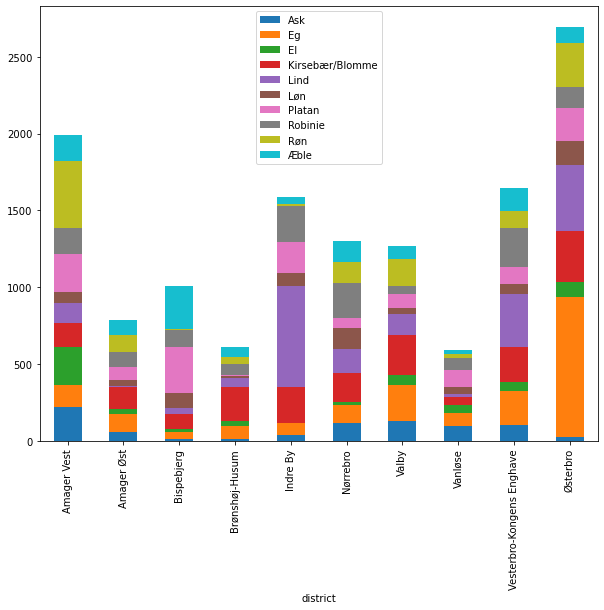

In [96]:
# Plot 4: 
df4 = df[df["species"].isin(tree_species)].groupby(['district','species']).size().reset_index()


df4new = (df4.pivot_table(0, ['district'], 'species')).reset_index()
df4new.plot(x='district',kind='bar',stacked=True,figsize=(10,8)).legend(loc='upper center')
plt.show()


In [ ]:


data = df[['district']]


# Create weight column, using time
data['Weight'] = data['Time'].str[0:2] # Weight corresponds to hours (0-23)
data['Weight'] = data['Weight'].astype(float)
# List comprehension 
heat_data = [[row['Y'],row['X']] for index, row in data.iterrows()]

# Plot it on the map
lat = 55.6761
lon = 12.5683
map = folium.Map(location=[lat, lon],zoom_start = 12)
HeatMap(heat_data,radius=10,blur=10).add_to(map)

# Show map 
map

In [107]:
heat_data = pd.DataFrame()
heat_data[['Y','X', "Weight"]] = df[['Y','X', "year"]]
# Create weight column, using time
#heat_data['Weight'] = df['year']
heat_data['Weight'] = heat_data['Weight'].astype(float)

heat_data = heat_data.dropna(axis=0, subset=['Y','X', 'Weight'])


heat_data = [[[row['Y'],row['X']] for index, row in heat_data[heat_data['Weight'] == i].iterrows()] for i in range(2000,2023)]
# Plot it on the map
lat = 55.6761
lon = 12.5683
map = folium.Map(location=[lat, lon],zoom_start = 12)
hm = HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)
map